## Setup

In [63]:
try:
  import torch
  from nlpcw.utils import get_dataset, show_random_elements
  from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
  import matplotlib.pyplot as plt
  import seaborn as sns
  from collections import Counter
  from itertools import combinations
  import numpy as np
  import pandas as pd
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
  import wandb
  import gradio as gr
except:
  %pip install gradio
  %pip install -q "git+https://github.com/cogniveon/nlpcw.git"

In [49]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("rohit-k-kesavan/COMM061-NLP-CW")

summary_list, config_list, name_list, id_list = [], [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)
    id_list.append(run.id)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)


def map_summary_to_columns(
    df,
    summary_keys: list[str] = ["eval/f1", "eval/loss", "eval/precision", "eval/recall", "eval/accuracy", "train/loss", "train/epoch"],
    config_keys: list[str] = ["per_device_train_batch_size", "learning_rate", "weight_decay", "model/num_parameters",  "optim", "lr_scheduler_type"]
):
  new_df = df.copy()
  new_df['id'] = df['id_list']
  for key in summary_keys:
    new_df[key] = df['summary'].apply(lambda x: x.get(key))
  for key in config_keys:
    new_df[key] = df['config'].apply(lambda x: x.get(key))
  new_df.drop(columns=['summary', 'config', 'id_list'], inplace=True)
  return new_df


runs_df = pd.DataFrame({
  "summary": summary_list,
  "config": config_list,
  "name": name_list,
  "id_list": id_list
})

runs_df = map_summary_to_columns(runs_df)

model_exps = [
  "romainlhardy-roberta-large-finetuned-ner",
  "google-bert-bert-base-uncased",
  "google-bert-bert-large-uncased",
  "pucpr-biobertpt-all",
  "romainlhardy-finetuned-ner",
]

model_exps_df = runs_df[runs_df["name"].isin(model_exps)]
optuna_exps_df = runs_df[~runs_df["name"].isin(model_exps)]

## Plots

In [32]:
model_exps_df

,name,id,eval/f1,eval/loss,eval/precision,eval/recall,eval/accuracy,train/loss,train/epoch,per_device_train_batch_size,learning_rate,weight_decay,model/num_parameters,optim,lr_scheduler_type
0,romainlhardy-roberta-large-finetuned-ner,1qtqulxa,0.944804,0.209842,0.948358,0.941276,0.939251,0.1542,20,8,0.000001,0.001,354314244,adamw_torch,linear
1,google-bert-bert-base-uncased,ykwkccm1,0.913392,0.266949,0.916196,0.910605,0.908536,0.3481,15,8,0.000001,0.001,108894724,adamw_torch,linear
2,google-bert-bert-large-uncased,ml4hubbx,0.920609,0.243737,0.923205,0.918027,0.917545,0.2277,19,8,0.000001,0.001,334096388,adamw_torch,linear
3,pucpr-biobertpt-all,z6kr4wit,0.917582,0.262461,0.921143,0.914048,0.911317,0.3196,15,8,0.000001,0.001,177265924,adamw_torch,linear
4,romainlhardy-finetuned-ner,kur2z4sn,0.922593,0.241025,0.926306,0.918910,0.917798,0.2350,19,8,0.000001,0.001,107722756,adamw_torch,linear


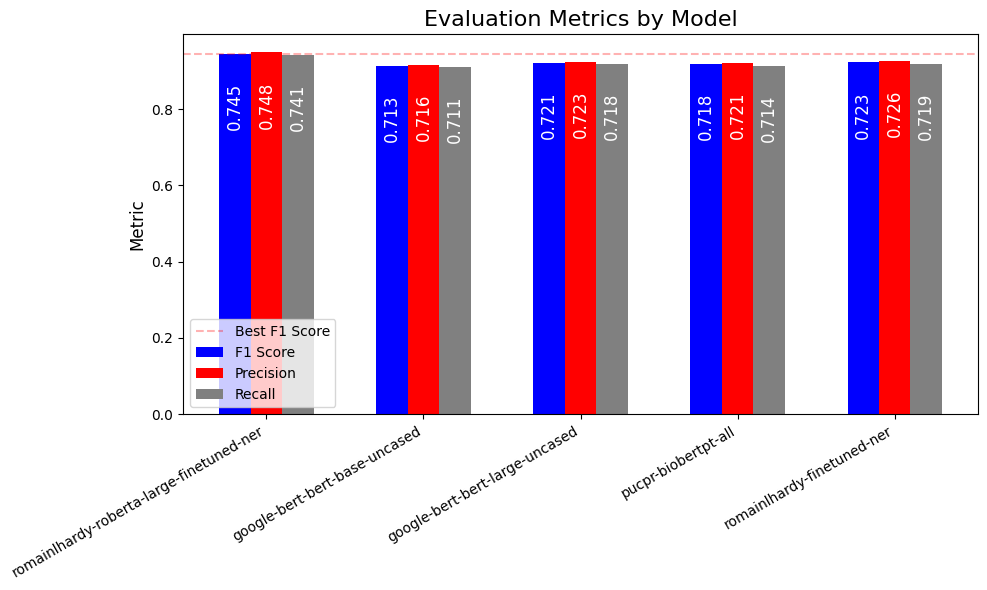

In [5]:
def plot_metrics(df, ax, bar_width = 0.2):
  eval_positions = np.arange(len(df['name']))
  precision_positions = eval_positions + bar_width
  recall_positions = eval_positions + 2 * bar_width

  f1_bars = ax.bar(eval_positions, df['eval/f1'], bar_width, label='F1 Score', color="blue")
  precision_bars = ax.bar(precision_positions, df['eval/precision'], bar_width, label='Precision', color="red")
  recall_bars = ax.bar(recall_positions, df['eval/recall'], bar_width, label='Recall', color="gray")

  for bars, metric in zip([f1_bars, precision_bars, recall_bars], ['eval/f1', 'eval/precision', 'eval/recall']):
    for bar in bars:
      yval = bar.get_height() - 0.2
      ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}',
              ha='center', va='bottom', fontsize=12, color="white", rotation="vertical")

  best_f1_score = df['eval/f1'].max()
  ax.axhline(y=best_f1_score, color='red', linestyle='--', alpha=0.3, label='Best F1 Score')

  ax.set_title('Evaluation Metrics by Model', fontsize=16)
  ax.set_ylabel('Metric', fontsize=12)
  # ax.set_xlabel('Model Name', fontsize=12)
  ax.set_xticks(eval_positions + bar_width)  # Center the x-ticks between the bars
  ax.set_xticklabels(df['name'], rotation=30, ha='right', fontsize=10)
  ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
plot_metrics(model_exps_df, ax)
plt.tight_layout()
plt.show()

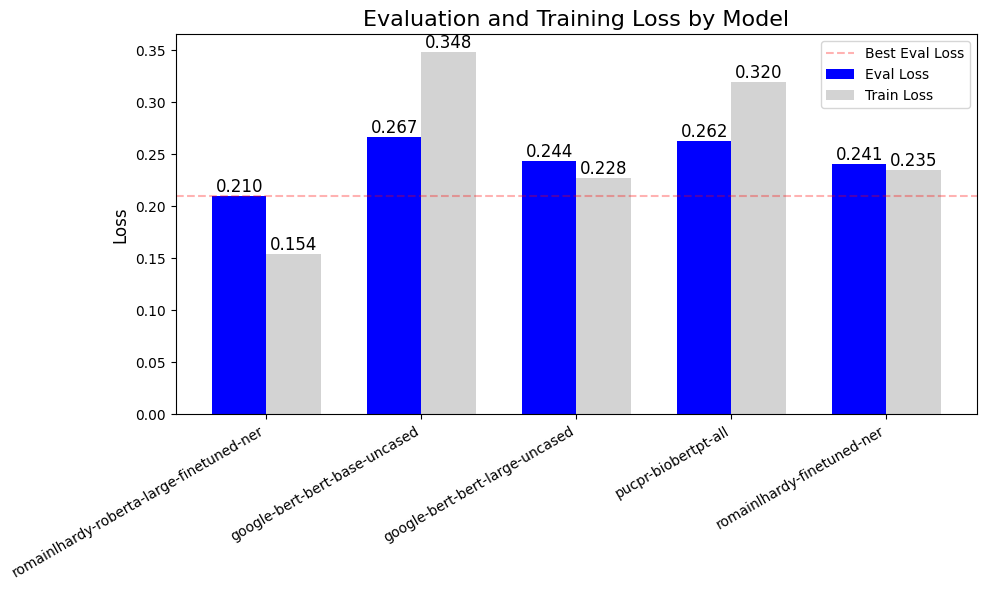

In [6]:
def plot_losses(df, ax, bar_width = 0.35):
  eval_positions = np.arange(len(df['name']))
  train_positions = eval_positions + bar_width

  eval_bars = ax.bar(eval_positions, df['eval/loss'], bar_width, label='Eval Loss', color="blue")
  train_bars = ax.bar(train_positions, df['train/loss'], bar_width, label='Train Loss', color="lightgray")

  for bar in eval_bars + train_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}',
            ha='center', va='bottom', fontsize=12)

  best_eval_loss = df['eval/loss'].min()
  ax.axhline(y=best_eval_loss, color='red', linestyle='--', alpha=0.3, label='Best Eval Loss')

  ax.set_title('Evaluation and Training Loss by Model', fontsize=16)
  ax.set_ylabel('Loss', fontsize=12)
  # ax.set_xlabel('Model Name', fontsize=12)
  ax.set_xticks(eval_positions + bar_width / 2)  # Center the x-ticks between the bars
  ax.set_xticklabels(df['name'], rotation=30, ha='right', fontsize=10)
  ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
plot_losses(model_exps_df, ax)
plt.tight_layout()
plt.show()


In [7]:
optuna_exps_df

,name,eval/f1,eval/loss,eval/precision,eval/recall,eval/accuracy,train/loss,train/epoch,per_device_train_batch_size,learning_rate,weight_decay,model/num_parameters,optim,lr_scheduler_type
5,wild-pond-17,0.946273,0.234263,0.950977,0.941616,0.940510,0.1148,8,8,0.000004,0.003131,354314244,adamw_torch,linear
6,fluent-sunset-18,0.955535,0.323089,0.961030,0.950102,0.948694,0.0113,10,12,0.000035,0.005490,354314244,adamw_torch,linear
7,pleasant-violet-19,0.955076,0.315100,0.959411,0.950781,0.948851,0.0144,10,8,0.000031,0.007522,354314244,adamw_torch,linear
8,polar-vortex-20,0.944724,0.204633,0.948196,0.941276,0.938936,0.1758,14,8,0.000001,0.004573,354314244,adamw_torch,linear
9,eager-valley-21,0.955247,0.350624,0.959582,0.950950,0.948851,0.0123,12,8,0.000030,0.000384,354314244,adamw_torch,linear
10,worthy-rain-22,0.943399,0.193605,0.950551,0.936354,0.937834,0.2560,1,8,0.000023,0.009967,354314244,adamw_torch,linear
11,confused-silence-23,0.953453,0.334989,0.957862,0.949084,0.947749,0.0067,18,4,0.000084,0.003370,354314244,adamw_torch,linear
12,denim-hill-24,0.947243,0.255295,0.951378,0.943143,0.941139,0.1140,10,4,0.000002,0.009390,354314244,adamw_torch,linear
13,floral-fire-25,0.945851,0.312933,0.950471,0.941276,0.940667,0.0370,9,12,0.000066,0.005694,354314244,adamw_torch,linear
14,easy-sponge-26,0.939451,0.214181,0.949549,0.929566,0.932169,0.2542,1,4,0.000019,0.001901,354314244,adamw_torch,linear


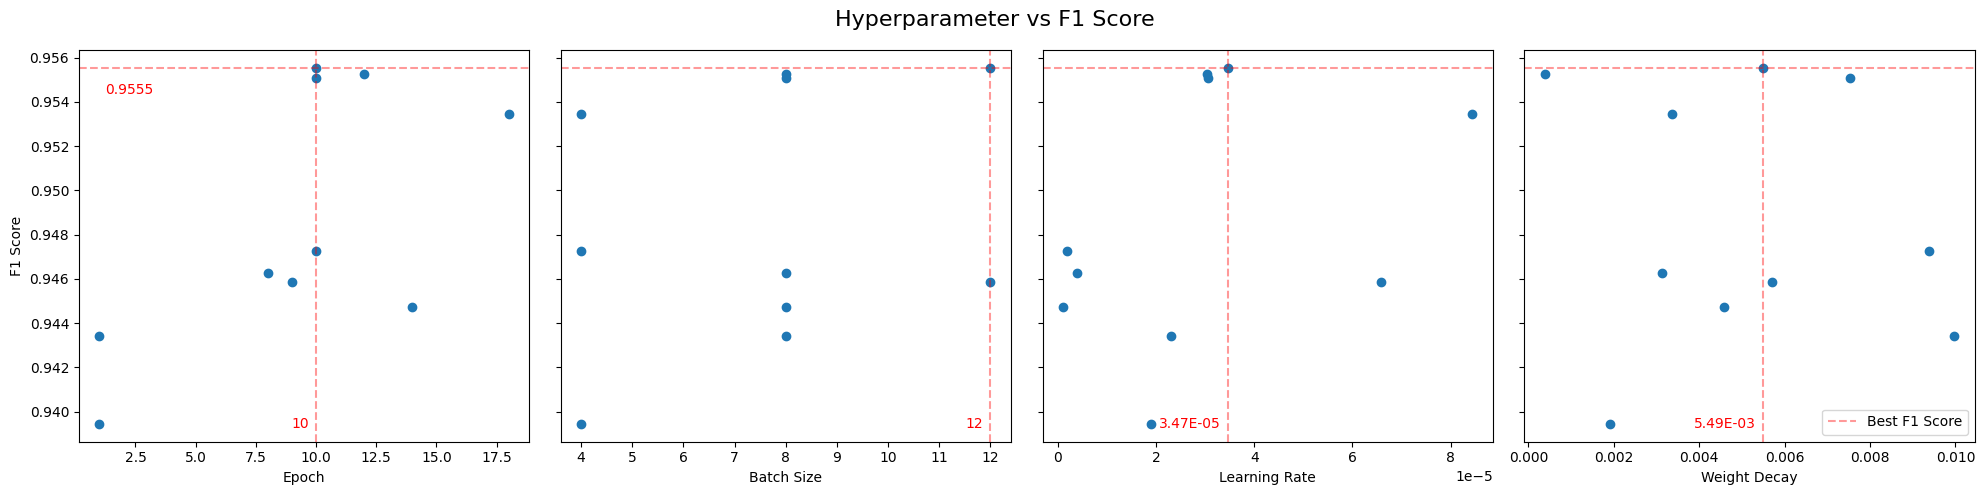

In [8]:
import matplotlib.pyplot as plt
from decimal import Decimal

n_axes = {'train/epoch': 'Epoch', 'per_device_train_batch_size': 'Batch Size', 'learning_rate': 'Learning Rate', 'weight_decay': 'Weight Decay'}

best_f1_index = optuna_exps_df['eval/f1'].idxmax()
best_f1_row = optuna_exps_df.loc[best_f1_index]

fig, axes = plt.subplots(1, len(n_axes), figsize=(20, 5), sharey=True)

for i, x in enumerate(n_axes.items()):
    x, label = x
    axes[i].scatter(optuna_exps_df[x], optuna_exps_df['eval/f1'])
    axes[i].axvline(x=best_f1_row[x], color='red', linestyle='--', alpha=0.4, label='Best F1 Score')
    axes[i].axhline(y=best_f1_row['eval/f1'], color='red', linestyle='--', alpha=0.4)
    axes[i].set_xlabel(label)
    if i == 0:
        axes[i].set_ylabel('F1 Score')


    axes[i].annotate(f"{best_f1_row[x]}" if i < 2 else f"{'%.2E' % Decimal(best_f1_row[x])}",
                      xy=(best_f1_row[x], 0),
                      xycoords=('data', 'axes fraction'),
                      xytext=(-5, 10),
                      textcoords='offset points',
                      ha='right',
                      color='red')

axes[0].annotate(f"{best_f1_row['eval/f1']:.4f}",
                      xy=(best_f1_row['eval/f1'], 0),
                      xycoords=('data', 'axes fraction'),
                      xytext=(5, 250),
                      textcoords='offset points',
                      ha='left',
                      color='red')

fig.suptitle('Hyperparameter vs F1 Score', fontsize=16)
plt.tight_layout()
plt.legend()
plt.show()

In [34]:
best_run_id = runs_df['eval/f1'].idxmax()
best_run = runs_df.loc[best_run_id]
best_run

,6
name,fluent-sunset-18
id,ohl8nyzy
eval/f1,0.955535
eval/loss,0.323089
eval/precision,0.96103
eval/recall,0.950102
eval/accuracy,0.948694
train/loss,0.0113
train/epoch,10
per_device_train_batch_size,12


In [53]:
run = api.run(f"rohit-k-kesavan/COMM061-NLP-CW/{best_run['id']}")
best_model_artifact = api.artifact(f"rohit-k-kesavan/COMM061-NLP-CW/model-{run.files().variables['name']}:latest")
checkpoint_dir = best_model_artifact.download()
checkpoint_dir

wandb: Downloading large artifact model-ohl8nyzy:latest, 1354.86MB. 9 files... 
wandb:   9 of 9 files downloaded.  
Done. 0:0:27.4


'/content/artifacts/model-ohl8nyzy:v1'

In [56]:
dataset, id2label, label2id, num_labels = get_dataset()
tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
model = AutoModelForTokenClassification.from_pretrained(checkpoint_dir)

tokenized_inputs = tokenizer(dataset['test']["tokens"], is_split_into_words=True, padding=True, return_tensors="pt")
attention_mask = tokenized_inputs['attention_mask']

with torch.no_grad():
  output = model(**tokenized_inputs).logits
predictions = torch.argmax(output, dim=2)
pred_labels = predictions.detach().cpu().numpy()
true_labels = dataset['test']["ner_tags"]

flat_predictions = []
flat_true_labels = []

for i, labels in enumerate(true_labels):
    # Get the length of the current sequence before padding/truncation
    seq_len = len(labels)

    # Ensure predictions and true labels are aligned by using sequence length
    valid_labels = np.array(labels) != -100  # Assuming -100 is the ignore index used during training

    flat_predictions.extend([label for j, label in enumerate(pred_labels[i][:seq_len]) if valid_labels[j]])
    flat_true_labels.extend([label for j, label in enumerate(labels[:seq_len]) if valid_labels[j]])

f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')

accuracy = accuracy_score(flat_true_labels, flat_predictions)

precision = precision_score(flat_true_labels, flat_predictions, average='weighted')

recall = recall_score(flat_true_labels, flat_predictions, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1072 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/126 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/153 [00:00<?, ? examples/s]

F1 Score: 0.7392
Accuracy: 0.7118
Precision: 0.7696
Recall: 0.7118


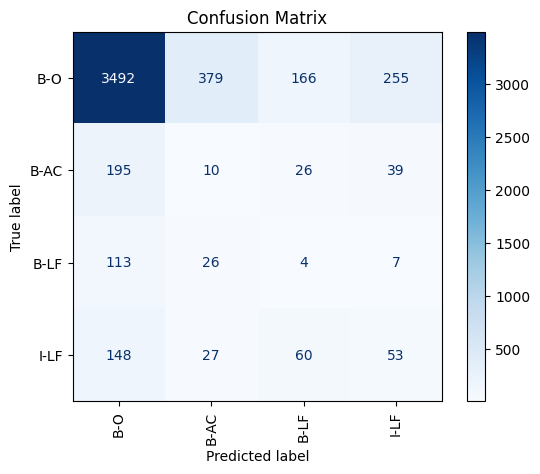

In [57]:
pred_label_str = [id2label[label] for label in flat_predictions]
true_label_str = [id2label[label] for label in flat_true_labels]

cm = confusion_matrix(true_label_str, pred_label_str, labels=[id2label[i] for i in range(num_labels) if id2label[i] != "I-AC"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in range(num_labels) if id2label[i] != "I-AC"])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [72]:
tokenizer.push_to_hub('cogniveon/nlpcw-ner')
model.push_to_hub('cogniveon/nlpcw-ner')

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/cogniveon/nlpcw-ner/commit/c72f5526509ca2c58f50201ad1e3ee48a5d0be61', commit_message='Upload RobertaForTokenClassification', commit_description='', oid='c72f5526509ca2c58f50201ad1e3ee48a5d0be61', pr_url=None, pr_revision=None, pr_num=None)